In [27]:
# Variables explaination link: https://api.census.gov/data/2010/dec/sf1/variables.html

"""
P001001	Total	TOTAL POPULATION	not required	P001001ERR	0	(not a predicate)	P1
P002001	Total	URBAN AND RURAL	not required	P002001ERR	0	int	P2
P002002	Total!!Urban	URBAN AND RURAL	not required		0	int	P2
P002003	Total!!Urban!!Inside urbanized areas	URBAN AND RURAL	not required		0	int	P2
P002004	Total!!Urban!!Inside urban clusters	URBAN AND RURAL	not required		0	int	P2
P002005	Total!!Rural	URBAN AND RURAL	not required		0	int	P2
P002006	Total!!Not defined for this file	URBAN AND RURAL	not required		0	int	P2
P003001	Total	RACE	not required	P003001ERR	0	int	P3
P003002	Total!!White alone	RACE	not required		0	int	P3
P003003	Total!!Black or African American alone	RACE	not required		0	int	P3
P003004	Total!!American Indian and Alaska Native alone	RACE	not required		0	int	P3
P003005	Total!!Asian alone	RACE	not required		0	int	P3
P003006	Total!!Native Hawaiian and Other Pacific Islander alone	RACE	not required		0	int	P3
P003007	Total!!Some Other Race alone	RACE	not required		0	int	P3
P003008	Total!!Two or More Races	RACE	not required		0	int	P3
P004001	Total	HISPANIC OR LATINO ORIGIN	not required	P004001ERR	0	int	P4
P004002	Total!!Not Hispanic or Latino	HISPANIC OR LATINO ORIGIN	not required		0	int	P4
P004003	Total!!Hispanic or Latino	HISPANIC OR LATINO ORIGIN
"""

# Dataset: https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

## 1 Load the dataset

In [28]:
df = pd.read_json("https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*")


new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
new_header[0] = 'Total'
new_header[1] = 'White'
new_header[2] = 'Black'
new_header[3] = 'Hispanic or Latino'
df.columns = new_header #set the header row as the df header
df.head(10)

,Total,White,Black,Hispanic or Latino,NAME,state,county
1,125744,96344,8019,15445,"Sebastian County, Arkansas",05,131
2,17058,11949,734,5220,"Sevier County, Arkansas",05,133
3,17264,16582,93,290,"Sharp County, Arkansas",05,135
4,12394,11995,11,157,"Stone County, Arkansas",05,137
5,41639,26276,13721,1460,"Union County, Arkansas",05,139
6,17295,16598,68,475,"Van Buren County, Arkansas",05,141
7,203065,162253,6006,31458,"Washington County, Arkansas",05,143
8,77076,70425,3074,2879,"White County, Arkansas",05,145
9,22185,19226,307,4230,"Yell County, Arkansas",05,149
10,21419,13854,195,11804,"Colusa County, California",06,011


In [166]:
df[False == df['NAME'].str.contains("County")].head(5)

,Total,White,Black,Hispanic or Latino,NAME,state,county
107,97581,75175,4423,5651,"Fairbanks North Star Borough, Alaska",02,090
111,3141,660,219,385,"Aleutians East Borough, Alaska",02,013
112,5561,2004,332,726,"Aleutians West Census Area, Alaska",02,016
113,1826,1637,10,42,"Denali Borough, Alaska",02,068
114,4847,878,11,101,"Dillingham Census Area, Alaska",02,070


After some research, we can observe that for instance, we have the datas for Carson City, from Nevada.
This City is not part of any county (source: https://en.wikipedia.org/wiki/Carson_City,_Nevada). 
Those entries will simply not be used, since we only use Police Stops with a County_name column specified

In [30]:
# Given a county name and a state name, returns the number of 
# total polulation, number of blacks and number of whites.
def getStatsByCounty(countyName, stateName, df):
    # Split the NAME column in "County/City Name" and "State"
    new_df = df.copy()
    new_df[['County_name', 'State_name']] = df['NAME'].str.split(',', 1, expand=True)
    matches = new_df[new_df['County_name'].str.contains(countyName)].copy()
    if(len(matches) == 0):
        # Try to remove dots from the county name 
        # i.e. "St. Johns County" is "St Johns counts" in the police dataset
        matches = new_df[new_df['County_name'].str.replace('.', '').str.contains("(?i)"+countyName)].copy()
            
    matches = matches[matches['State_name'].str.contains("(?i)"+stateName)].copy()
    
    matches['Total'] = pd.to_numeric(matches['Total'])
    matches['White'] = pd.to_numeric(matches['White'])
    matches['Black'] = pd.to_numeric(matches['Black'])
    matches['Hispanic or Latino'] = pd.to_numeric(matches['Hispanic or Latino'])
    
    if(len(matches) == 0):
        print("[getStatsByCounty] Error: County not found: ", countyName, " ", stateName)
        return;
    if(len(matches) == 1):
        return {'total': matches['Total'].values[0], 
                'white': matches['White'].values[0],
                'black': matches['Black'].values[0], 
             #   'hispanicy or latino': (matches['Hispanic or Latino']/matches['Total']).values[0]
               }
    else:
        print("[getStatyByCount] Error: Too many matches: ", countyName)
        print(matches[['County_name', 'State_name']])
        return;



In [31]:
getStatsByCounty('new york', '', df)

{'total': 1585873, 'white': 911073, 'black': 246687}

The Cencus dataset can now be queried with getStatsByCounty function.
We only get the numbre of black and white prople. The cencus datas does not provides the number of "hispanics race", but only the number of persons with "hispanic origin". Hence a black or a white can have hispanic origins, making it tricky to analyse.

## 2 Analisis of the stop rate

In this part, we will analyse the **rate of white stops** and the **rate of black stops**.

Our assumption is that in an unbiaised environement, whites prople should be stopped at the same rate as blacks people.

To compute the **rate of white stops** we will use the number of white stops in a County, and the number of whites registered in the Cencus data of that County. We will do the same for the **rate of black stops**

We will also split the rates into two groups: if the police officer race is white or black.

### 2.1 Prepare the datas

In [50]:
import pandas as pd
data = pd.read_csv('data/data.csv', low_memory=False)

del data['search_conducted']
del data['contraband_found']
del data['date']
data.dropna();

/home/yata/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:

data = data[(data['subject_race'] == 'white') | (data['subject_race'] == 'black')]
data = data[(data['officer_race'] == 'white') | (data['officer_race'] == 'black')]
data['total_stops'] = 1
data_total_stops = data.groupby(['county_name', 'state', 'subject_race', 'officer_race']).sum()


In [165]:
data_total_stops = data_total_stops.reset_index()
data = data_total_stops
data.head(5)

,level_0,index,county_name,state,subject_race,officer_race,total_stops
0,0,0,Abbeville County,SC,black,black,391
1,1,1,Abbeville County,SC,black,white,13685
2,2,2,Abbeville County,SC,white,black,986
3,3,3,Abbeville County,SC,white,white,24484
4,4,4,Adams County,WA,black,white,3025


We can observe that the state in the police stops dataset is in the two letters Alpha code representation (i.e. AL). In the cencus dataset, the state columns contains the state name (i.e. Alabama).

A mapping dictionary has been found and used on github:https://gist.github.com/rogerallen/1583593



In [57]:
# From https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [58]:
data_states_mapped = data.copy()
# Replace the state names
data_states_mapped['state'] = data['state'].map(abbrev_us_state)
# Create the cencus column for the cencus datas
data_states_mapped['cencus'] = data_states_mapped.apply(lambda x: getStatsByCounty(x['county_name'], x['state'], df), axis=1)

# Display Thomas County entry
data_states_mapped[data_states_mapped['county_name'] == 'Thomas County']

[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Thomas County   Florida


,county_name,state,subject_race,officer_race,total_stops,cencus
528,Thomas County,Florida,white,white,1,None


We can observe that in the Florida dataset, there is one arrest in the Thomas County! This county is not in florida, but in Georgia, very close to the florida border. These entry will be removed. Same for the other counties registered in the wrong state.
The "Dillion County" from the police stops dataset has been misspelled, the real county name is "Dillon County". Same for "Claredon County" which is "Clarendon County".

In [59]:
# Correct misspeled county_name cencus data
# Dillon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Dillion County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Dillion County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)
# Clarendon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Claredon County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Claredon County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)

# Remove NaN cencus data (for instance Thomas County not been found in the Florida cencus datas)
data_states_mapped = data_states_mapped[data_states_mapped['cencus'].notna()]

In [163]:
data_states_mapped.head(5)

,county_name,state,subject_race,officer_race,total_stops,cencus
0,Abbeville County,South Carolina,black,black,391,"{'total': 25417, 'white': 17691, 'black': 7187}"
1,Abbeville County,South Carolina,black,white,13685,"{'total': 25417, 'white': 17691, 'black': 7187}"
2,Abbeville County,South Carolina,white,black,986,"{'total': 25417, 'white': 17691, 'black': 7187}"
3,Abbeville County,South Carolina,white,white,24484,"{'total': 25417, 'white': 17691, 'black': 7187}"
4,Adams County,Washington,black,white,3025,"{'total': 18728, 'white': 11703, 'black': 109}"


### 2.2 Overall stop rate
We will now extract the rate of black people stopped and the rate of white people stopped.

In [61]:
def extractRate(race, total_stops, cencus_data):
    if race == 'black':
        return total_stops/cencus_data['black']
    else:
        return total_stops/cencus_data['white']

rates = data_states_mapped.copy()
rates['race_stop_rate'] = data_states_mapped.apply(lambda x: extractRate(x['subject_race'], x['total_stops'], x['cencus']) , axis=1)
rates.head(5)

/home/yata/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,county_name,state,subject_race,officer_race,total_stops,cencus,race_stop_rate
0,Abbeville County,South Carolina,black,black,391,"{'total': 25417, 'white': 17691, 'black': 7187}",0.054404
1,Abbeville County,South Carolina,black,white,13685,"{'total': 25417, 'white': 17691, 'black': 7187}",1.904132
2,Abbeville County,South Carolina,white,black,986,"{'total': 25417, 'white': 17691, 'black': 7187}",0.055735
3,Abbeville County,South Carolina,white,white,24484,"{'total': 25417, 'white': 17691, 'black': 7187}",1.383981
4,Adams County,Washington,black,white,3025,"{'total': 18728, 'white': 11703, 'black': 109}",27.752294


In [62]:
# Dataset cleaning
# Remove entries where the rate of black or white if "inf"
# That would mean that no black/white are registered in the cencus dataset
county_to_remove = rates[False == rates['race_stop_rate'].replace([np.inf, -np.inf], np.nan).notna()]['county_name'].values
length_before = len(rates);
rates = rates[False == rates['county_name'].isin(county_to_remove)]
print((length_before - len(rates))/2, " counties removed");

1.0  counties removed


In [170]:
rates_black_officer = rates[rates['officer_race'] == 'black'].copy()
rates_white_officer = rates[rates['officer_race'] == 'white'].copy()

# officer black
black_stop_rate_officer_black = rates_black_officer[rates_black_officer['subject_race'] == 'black']['race_stop_rate']
white_stop_rate_officer_black = rates_black_officer[rates_black_officer['subject_race'] == 'white']['race_stop_rate']

# officer white
black_stop_rate_officer_white = rates_white_officer[rates_white_officer['subject_race'] == 'black']['race_stop_rate']
white_stop_rate_officer_white = rates_white_officer[rates_white_officer['subject_race'] == 'white']['race_stop_rate']

print("Black stop rate by black officer. [mean]=", black_stop_rate_officer_black.mean(), "[std]=", black_stop_rate_officer_black.std())
print("White stop rate by black officer. [mean]=", white_stop_rate_officer_black.mean(), "[std]=", white_stop_rate_officer_black.std())
print("Black stop rate by white officer. [mean]=", black_stop_rate_officer_white.mean(), "[std]=", black_stop_rate_officer_white.std())
print("White stop rate by white officer. [mean]=", white_stop_rate_officer_white.mean(), "[std]=", white_stop_rate_officer_white.std())


Black stop rate by black officer. [mean]= 0.14046770177862478 [std]= 0.22264205130533504
White stop rate by black officer. [mean]= 0.1374946899592965 [std]= 0.31047276374554905
Black stop rate by white officer. [mean]= 1.9102578671240205 [std]= 3.0628330649889937
White stop rate by white officer. [mean]= 1.13812818937867 [std]= 1.092617959047836


### Observation
#### Black officer
We can observe that black officers arrest black and white people at a similar rate

#### White officer
We can observe that white officers tends to arrest black people at a higher rate than white people.

#### Note
The observed stop rate is different than the one in the paper, since here we are using all the stops datas. In the paper, the stop rate is the average annual per-capita stop rates across the states and cities analysed

### 2.3 Difference in the stops rates for each County

In this part, we will analyse how many counties have a black stop rate greater than the black stop rate.

For that, we will use a ratio:
$ ratio = white\_stop\_rate / black\_stop\_rate $

If $ratio > 1$, the whites people are arrested more often that the black people
if $ratio < 1$, the blacks people are arrested more often.

In [130]:
# We now have the rate of black people stopped and the rate of white people stopped
# We will now compute the ratio of those two different rates
# ratio = r_white / w_black

# If we have ratio > 1:  The rate of white stopped is greater than the rate of black stopped
# If we have ration < 0: The rate of black stopped is greater than the rate of white stopped

def computeRatio(white_rate, black_rate):
    return white_rate / black_rate;

def extract_ratio(race, race_stop_rate):
    if (len(race_stop_rate) != 2):
        return None;
    if(race.iloc[0] == 'white'):
        return computeRatio(race_stop_rate.iloc[0], race_stop_rate.iloc[1])
    else:
        return computeRatio(race_stop_rate.iloc[1], race_stop_rate.iloc[0])

def appl_merge_rows(x):
    ratio = extract_ratio(x['subject_race'], x['race_stop_rate'])
    return pd.Series({'total_stops':x['total_stops'].sum(), 'ratio':ratio, 'cencus': x['cencus'].values[0]})
    
ratios = rates.groupby(['county_name', 'state', 'officer_race']).apply(lambda x: appl_merge_rows(x))

# remove NaN values
# for instance if there is no stops between "black officer and black subject" in a county, the ratio is NaN
ratios = ratios[ratios['ratio'].notna()].reset_index();

ratios_black_officer = ratios[ratios['officer_race'] == 'black'];
ratios_white_officer = ratios[ratios['officer_race'] == 'white'];

ratios.head(5)

,county_name,state,officer_race,total_stops,ratio,cencus
0,Abbeville County,South Carolina,black,1377,1.024461,"{'total': 25417, 'white': 17691, 'black': 7187}"
1,Abbeville County,South Carolina,white,38169,0.726830,"{'total': 25417, 'white': 17691, 'black': 7187}"
2,Adams County,Washington,white,68488,0.201558,"{'total': 18728, 'white': 11703, 'black': 109}"
3,Aiken County,South Carolina,black,28295,0.612654,"{'total': 160099, 'white': 111457, 'black': 39..."
4,Aiken County,South Carolina,white,246031,0.586143,"{'total': 160099, 'white': 111457, 'black': 39..."


Number of Counties with white_stop_rate > black_stop_rate (officer black):  31
Number of Counties with white_stop_rate < black_stop_rate (officer black):  100
Number of Counties with white_stop_rate > black_stop_rate (officer white):  33
Number of Counties with white_stop_rate < black_stop_rate (officer white):  119


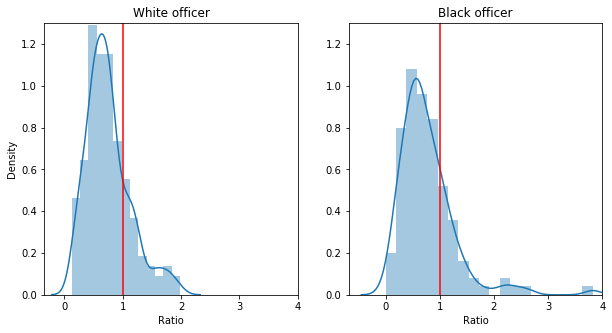

Info: Ratio > 1 when the rate of white stops is greater than the rate of black stops


In [182]:
import warnings
warnings.filterwarnings('ignore')
print("Number of Counties with white_stop_rate > black_stop_rate (officer black): ", len(ratios_black_officer[ratios_black_officer['ratio'] > 1]))
print("Number of Counties with white_stop_rate < black_stop_rate (officer black): ", len(ratios_black_officer[ratios_black_officer['ratio'] < 1]))

print("Number of Counties with white_stop_rate > black_stop_rate (officer white): ", len(ratios_white_officer[ratios_white_officer['ratio'] > 1]))
print("Number of Counties with white_stop_rate < black_stop_rate (officer white): ", len(ratios_white_officer[ratios_white_officer['ratio'] < 1]))

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(ratios_white_officer['ratio'].values, ax=axes[0])
sns.distplot(ratios_black_officer['ratio'].values, ax=axes[1])
plt.title('Distribution of the ratios')
axes[0].set_ylim(ymax=1.3)
axes[0].set_xlim(xmax=4)
axes[0].set_title('White officer')
axes[1].set_ylim(ymax=1.3)
axes[1].set_xlim(xmax=4)
axes[1].set_title('Black officer')

axes[0].axvline(x=1, color='red')
axes[1].axvline(x=1, color='red')

axes[0].set_xlabel('Ratio')
axes[1].set_xlabel('Ratio')
axes[0].set_ylabel('Density')

plt.show()

print("Info: Ratio > 1 when the rate of white stops is greater than the rate of black stops")

#### Observation

We can observe that the black stops rate is ofter greater than the white stops rate (ratio < 1).

It seems that the officer rate does not make a significant difference at the County level.


Text(0.5, 1.0, 'Black officer')

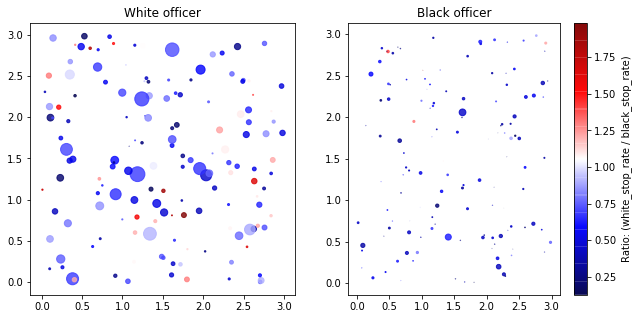

In [162]:
np.random.seed(142)

# reduce the size of the total_stops column
total_stops = (ratios['total_stops']/ratios['total_stops'].mean())

def ratioPlot(df, ax):
    N = len(df)
    x = np.random.rand(N)*3
    y = np.random.rand(N)*3
    colors = np.random.rand(N)
    area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

    return ax.scatter(x, y, alpha = .8, s=df['total_stops'].values/3000, c = df['ratio'].values, cmap = 'seismic')
    
fig, axes = plt.subplots(1, 2, figsize=(12,5))

im = ratioPlot(ratios[ratios['officer_race'] == 'white'], axes[0])   

ratioPlot(ratios[ratios['officer_race'] == 'black'], axes[1])   

fig.subplots_adjust(right=0.8)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Ratio: (white_stop_rate / black_stop_rate)')


axes[0].set_title('White officer')
axes[1].set_title('Black officer')


#### Observation
In the figure above, we can observe a lot of blue circles. Each circle is a County and the area of the circle is defined by the number of stops in the County.

We can observe that at the county level, the black stop rate is higher than the white stop rate. Further more, the black officer rate does seems to reverse this balance. 


### Conclusion
These numbers are a starting point for understanding racial disparities in traffic stops, but they do not, per se, provide strong evidence of racially disparate treatment. In particular, stop rates do
not account for possible race-specific differences in driving behaviour,
including amount of time spent on the road and adherence to traffic
laws. For example, if black drivers, hypothetically, spend more time on
the road than white drivers, that could explain the higher stop rates we
see for the former, even in the absence of discrimination. 

### Confidence interval ( à supprimer je pense ou refaire....)

Now we will observe how confident we are about those results.
The first step is to measure the biais.
Different formula can apply. Here, we will just apply:
$\sum_{\forall C\in\vec{Counties}} number\_of\_stops*(ratio - 1)$

$(ratio - 1)$ is positive if there the rate of white stops is greater than the rate of black stops

$(ratio - 1)$ is negative if there the rate of black stops is greater than the rate of white stops

We have decided that the number of data should influence the weight of the biais, this is why the **number_of_stops** is taken into account

In [299]:
# Compute the biais
def compute_biais(df):
    return df.apply(lambda x: x['total_stops'] * (x['ratio'] - 1), axis = 1).sum()

biais = compute_biais(ratios)
print("The biais in the ratios is: ", biais)
print("The mean of the ratios is: ", ratios['ratio'].mean())
print("The std of the ratios is: ", ratios['ratio'].std())

The biais in the ratios is:  -4471128.574947493
The mean of the ratios is:  0.7409052347706728
The std of the ratios is:  0.3757967199797347


This "huge" number does not mean much by itself. We can just observe that overall, with this negative number, we can make the hypothesis that the rate of black stops is greater than the rate of white stops. Furthermore, the mean lower than 1 embrace this hypothesis.

The second step is to generate a confidence interval of a **random** police stops.
For instance, in **"Abbeville County"**, there is $14077 + 25472 = 39 549$ police stops. There is also $17691 + 7187 = 24878$ black and white registered in the Cencus. You may note that the police stops is greater that the number of habitants registered in the Cencus dataset. This is because the police stops are over a period of many years. Furthermore, the Cencus may be imcomplete, and computed differently in different counties.
With a random police stop in **Abbeville County**, the probability to arrest a black person is $p = 7187/25878 = 0.29$.

The experience that we will run is that for **Abbeville County**, 39549 persons will be "stopped", with a probability $p$ to arrest a black person, and $1-p$ to arrest a white person. 
To summarize, for each County, we will create an artificial and random dataset of black and white random police stops, knowing the number of black and whites in that County.

Finally, we will compute the biais of each experience, as done in step 1.

In [302]:
import random
def create_random_df(cencus_df):
    def generate_black_white_stops(number_of_whites, number_of_blacks, total_stops):
        # p is the probability to pick a white person
        p = number_of_whites/(number_of_whites + number_of_blacks);
        blacks = 0;
        whites = 0;
        for i in range(total_stops):
            if(random.uniform(0, 1) < p):
                whites = whites + 1;
            else:
                blacks = blacks + 1;
                
        white_rate = extractRate('white', whites, {'white': number_of_whites,'black': number_of_blacks});
        black_rate = extractRate('black', blacks, {'white': number_of_whites,'black': number_of_blacks})
        
        return pd.Series({'total_stops':whites+blacks, 'ratio': computeRatio(white_rate, black_rate)});
    
    return cencus_df.apply(lambda x: generate_black_white_stops(x['cencus']['white'], x['cencus']['black'], x['total_stops']), axis = 1)

# Display a random DF
create_random_df(ratios.head(10)).head(10)

        

,total_stops,ratio
county_name,,
Abbeville County,39549.0,0.997825
Adams County,71317.0,0.974739
Aiken County,276471.0,0.993298
Alachua County,46494.0,0.996193
Allendale County,33218.0,0.997291
Anderson County,460883.0,0.998291
Asotin County,12652.0,1.052533
Baker County,25096.0,1.006252
Bamberg County,58487.0,1.005147


We can observe in the dataframe above a dataset of random arrests, generated with the Cencus datas. Each police stop is random among the population of the County.

In [308]:
# Compute the biais
def compute_biais_of_random_df(df):
    biais = df.apply(lambda x: x['total_stops']*(x['ratio'] - 1), axis = 1).sum()
    return biais

random_df = create_random_df(ratios);
biais = compute_biais_of_random_df(random_df)

print("The biais of the ratios is: ", biais)
print("The mean of the ratios is: ", random_df['ratio'].mean())
print("The std of the ratios is: ", random_df['ratio'].std())

The biais of the ratios is:  -20480.147385861907
The mean of the ratios is:  1.0034907478343364
The std of the ratios is:  0.05679686564035286


We can observe the biais of a random police stops dataset. We will create a sample of 1000 different police-stops dataset, and plot the distribution of the biais. We can also observe that the std is lower in this sample, and that the mean is as expected around 1.

In [197]:
def confidence_interval_datas(df):
    biais = [];
    for i in range(700):
        biais.append(compute_biais_of_random_df(create_random_df(df)))
    
    return biais

random.seed(42);
biais = confidence_interval_datas(ratios)

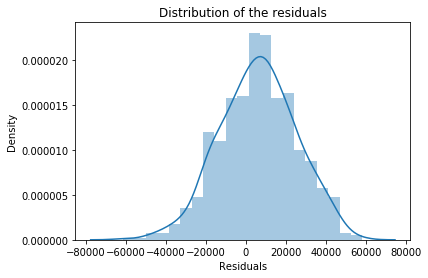

The confidence interval is [-32381.954983868694], 42286.82835519177]


In [199]:
sns.distplot(biais)
plt.title('Distribution of the residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

print(f'The confidence interval is [{np.nanpercentile(biais, 2.5)}], {np.nanpercentile(biais, 97.5)}]')

The observed biais in the real police stops dataset is outside of the confidence interval of the "racial unbiaised police stop datasets" generated with random police stops among the black and white population registered in the Cencus dataset. 

### Conclusion
These numbers are a starting point for understanding racial disparities in traffic stops, but they do not, per se, provide strong evidence of racially disparate treatment. In particular, stop rates do
not account for possible race-specific differences in driving behaviour,
including amount of time spent on the road and adherence to traffic
laws. For example, if black drivers, hypothetically, spend more time on
the road than white drivers, that could explain the higher stop rates we
see for the former, even in the absence of discrimination. 